In [1]:
import pandas as pd
import io
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import pylab as pl
import tensorflow.contrib.learn as skflow
import string

from sklearn.metrics import confusion_matrix, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.utils.multiclass import unique_labels
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
from inspect import signature


path = "KDDTrain+2.csv"
# This file is a CSV, just no CSV extension or headers
df = pd.read_csv(path, header=None)
df[0:3]

Using TensorFlow backend.


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,anomaly


In [2]:
df.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)

# The CSV file has no column heads, so add them
df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]
df[0:3]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,anomaly



Analyzing: KDDTrain+2.csv
125972 rows
** 0:2981 (2%)
** tcp:[tcp:81.52%,udp:11.9%,icmp:6.58%]
** ftp_data:[http:32.02%,private:17.35%,domain_u:7.18%,smtp:5.81%,ftp_data:5.44%,eco_i:3.64%,other:3.46%,ecr_i:2.44%,telnet:1.87%,finger:1.4%,ftp:1.39%,auth:0.76%,Z39_50:0.68%,uucp:0.62%,courier:0.58%,bgp:0.56%,whois:0.55%,uucp_path:0.55%,iso_tsap:0.55%,time:0.52%,imap4:0.51%,nnsp:0.5%,vmnet:0.49%,urp_i:0.48%,domain:0.45%,ctf:0.45%,csnet_ns:0.43%,supdup:0.43%,discard:0.43%,http_443:0.42%,daytime:0.41%,gopher:0.41%,efs:0.39%,systat:0.38%,link:0.38%,exec:0.38%,hostnames:0.37%,name:0.36%,mtp:0.35%,echo:0.34%,klogin:0.34%,login:0.34%,ldap:0.33%,netbios_dgm:0.32%,sunrpc:0.3%,netbios_ssn:0.29%,netstat:0.29%,netbios_ns:0.28%,ssh:0.25%,kshell:0.24%,nntp:0.23%,pop_3:0.21%,sql_net:0.19%,IRC:0.15%,ntp_u:0.13%,rje:0.07%,pop_2:0.06%,remote_job:0.06%,X11:0.06%,printer:0.05%,shell:0.05%,urh_i:0.01%,red_i:0.01%,tim_i:0.01%,pm_dump:0.0%,tftp_u:0.0%,http_8001:0.0%,aol:0.0%,harvest:0.0%,http_2784:0.0%]
** SF:[S

Train on 94479 samples, validate on 31494 samples
Epoch 1/1000
 - 4s - loss: nan - acc: 0.4648 - val_loss: nan - val_acc: 0.4674
Epoch 2/1000
 - 4s - loss: nan - acc: 0.4648 - val_loss: nan - val_acc: 0.4674
Epoch 3/1000
 - 4s - loss: nan - acc: 0.4648 - val_loss: nan - val_acc: 0.4674
Epoch 4/1000
 - 4s - loss: nan - acc: 0.4648 - val_loss: nan - val_acc: 0.4674
Epoch 5/1000
 - 4s - loss: nan - acc: 0.4648 - val_loss: nan - val_acc: 0.4674
Epoch 00005: early stopping
Validation score: 0.4673906140852226
['anomaly' 'normal']


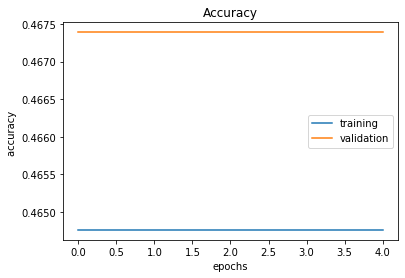

Confusion matrix, without normalization
[[14720     0]
 [16774     0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


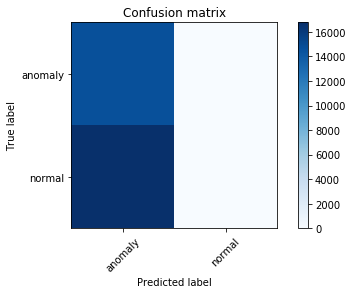

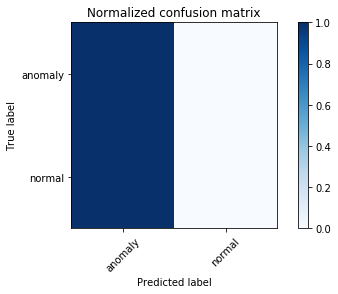

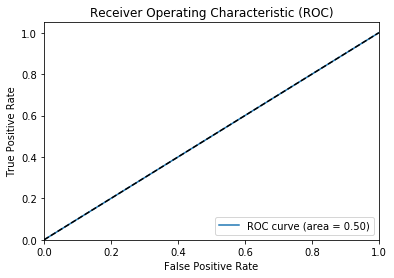

Average precision-recall score: 0.53


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.53')

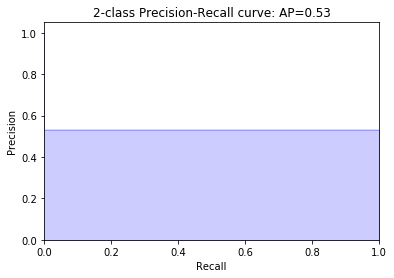

In [3]:
ENCODING = 'utf-8'

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(filename):
    print()
    print("Analyzing: {}".format(filename))
    df = pd.read_csv(filename,encoding=ENCODING)
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

analyze(path)


# display 5 rows
df[0:5]

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

#Clean 'date' column and convert to Int type
def clean_date(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    s_removed = s.replace(" ", "")
    s_int = int(s_removed)
    return s_int

########## CLEAN IP #######################
def clean_ip(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    s_int = int(s)
    return s_int

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

#MINMAX -1 1
# Encode a column to a range between normalized_low and normalized_high.
def min_max_1(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

#MINMAX 0 1
def min_max_0(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Now encode the feature vector

encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')
#encode_text_dummy(df, 'attack_tag')
outcomes = encode_text_index(df, 'outcome')
num_classes = len(outcomes)

# display 5 rows

#df.dropna(inplace=True,axis=1)
df[0:5]


##################################################
# Break into X (predictors) & y (prediction)
x, y = to_xy(df,'outcome')
#################################################



# Create a test/train split.  25% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print("Validation score: {}".format(score))

print(outcomes)

### PLOT ACCURACY ####

plt.plot(np.arange(len(history.history['acc'])),
history.history['acc'], label='training')
plt.plot(np.arange(len(history.history['val_acc'])),
history.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy ')
plt.legend(loc=0)
plt.show()

### PLOT CONFUSION MATRIX ###

# Not normalized
cm = confusion_matrix(y_eval, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, outcomes)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, outcomes, title='Normalized confusion matrix')

plt.show()

### PLOT ROC ###

#Plot an ROC. pred - the predictions, y - the expected outpus.
#En mi caso creo que es pred == pred y== y_eval
def plot_roc(pred, y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr,tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(pred, y_eval)


### PRECISION-RECALL ###

average_precision = average_precision_score(y_eval, pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))



precision, recall, _ = precision_recall_curve(y_eval, pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))